# Bilddatensatz für das Training und Testen vorbereiten

In [12]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

IMG_SIZE = 128

# Pfad zum Datensatz
data_dir = '/home/juebrauer/link_to_vcd/18_datasets/49_animal10/raw-img'

# Transformationen für die Bilder
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Bildgröße anpassen
    transforms.ToTensor(),         # In Tensor umwandeln
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisierung
])

# Gesamter Datensatz
full_dataset = ImageFolder(root=data_dir, transform=transform)

# Aufteilen in Training (90%) und Test (10%)
test_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - test_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader für Training und Test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Training samples: 23562, Test samples: 2617


In [2]:
len(full_dataset)

26179

In [3]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [4]:
len(train_loader)

737

In [5]:
len(train_dataset) / train_loader.batch_size

736.3125

# Das PyTorch CNN definieren

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Ein PyTorch Modell erstellen und trainieren

In [1]:
# Modell initialisieren
num_classes = len(full_dataset.classes)  # Automatisch Anzahl Klassen bestimmen
model = CNNModel(num_classes)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



def test_model():
    model.eval()  # Modell in Evaluationsmodus
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc


accs = []
num_epochs = 20
for epoch in range(num_epochs):
    print(f"epoch {epoch+1} of {num_epochs}")
    model.train()  # Modell in Trainingsmodus
    running_loss = 0.0

    batch_nr = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Vorwärts, Rückwärts, Optimieren
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        batch_nr += 1

        if batch_nr % 100 == 0:
            print(f"{batch_nr=} ", end=" ")
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    acc = test_model()
    accs.append( acc )

import matplotlib.pyplot as plt
plt.title("Lernkurve")
plt.xlabel("Epoche")
plt.ylabel("Klassifikationsgenauigkeit")
plt.plot( accs )
plt.show()

torch.save(model.state_dict(), 'cnn_animal10.pth')
print("Modell gespeichert!")

NameError: name 'full_dataset' is not defined

In [ ]:
type(torch.nn)

In [ ]:
print(str(model))

In [ ]:
for p in model.parameters():
    print(p.shape)

In [ ]:
len(test_loader)

In [31]:
model.eval()  # Modell in Evaluationsmodus
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()        

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 56.25%


In [32]:
len(test_loader)

82

In [33]:
images.shape

torch.Size([32, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].


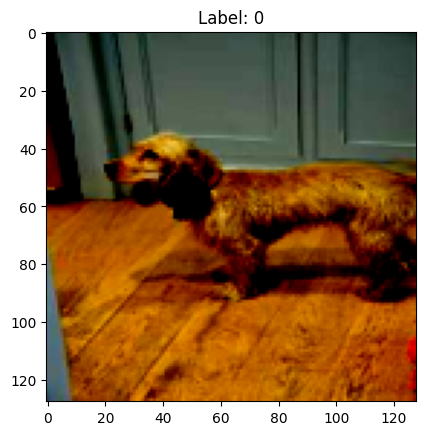

In [52]:
import matplotlib.pyplot as plt
imgid = 4
plt.imshow( images[imgid].cpu().permute(1, 2, 0) )
plt.title( f"Label: {labels[imgid].cpu()}" )
plt.show()

# Modell wiederherstellen

In [7]:
import torch
import torch.nn as nn

# Modellinstanz erstellen
num_classes = len(full_dataset.classes)  # Automatisch Anzahl Klassen bestimmen
model = CNNModel(num_classes)

# Parameter laden
model.load_state_dict(torch.load('cnn_animal10.pth'))

/tmp/ipykernel_5096/2206636386.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_animal10.pth'))


<All keys matched successfully>

# Modellinformationen anzeigen

In [8]:
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [9]:
!pip install torchinfo

In [13]:
from torchinfo import summary
summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE))  # Batchgröße 1, 3 Kanäle

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─MaxPool2d: 1-2                         [1, 32, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           18,496
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Linear: 1-5                            [1, 512]                  33,554,944
├─Linear: 1-6                            [1, 10]                   5,130
Total params: 33,579,466
Trainable params: 33,579,466
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 124.00
Input size (MB): 0.20
Forward/backward pass size (MB): 6.30
Params size (MB): 134.32
Estimated Total Size (MB): 140.81

In [14]:
134320000/33579466

4.000063610302797

In [15]:
all_parameters = [p for p in model.parameters()]

In [20]:
all_parameters[0].dtype

torch.float32

In [22]:
128*128*3*512

25165824